# Handwriting recognition

http://www.epaveldas.lt/ provides scanned images from Lithuanian archives about birth, marriage and death records from churches.

In [1]:
%matplotlib inline

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal

In [217]:
mpl.rc('figure', figsize=(16, 8))
mpl.rc('font', size=14)
mpl.style.use('seaborn-darkgrid')

In [4]:
def cleanup(im):
    return cv.adaptiveThreshold(
        im,
        255,                             # max value
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        15,                              # gausian window size
        16,                              # adaptive threshold value
    )

In [205]:
def imshow(im, title=None):
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

## There are different styles and sizes of hand-written text

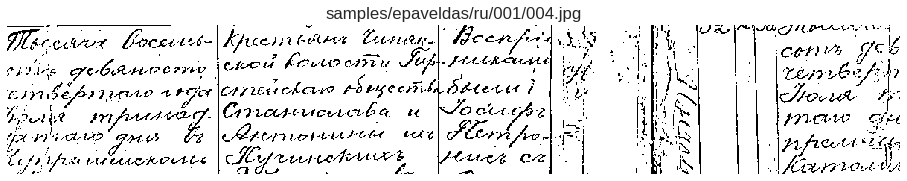

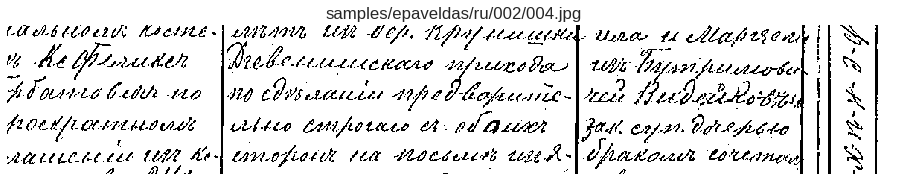

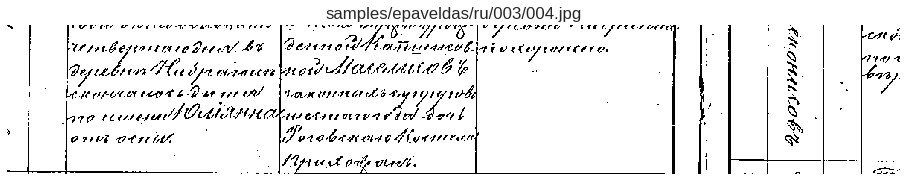

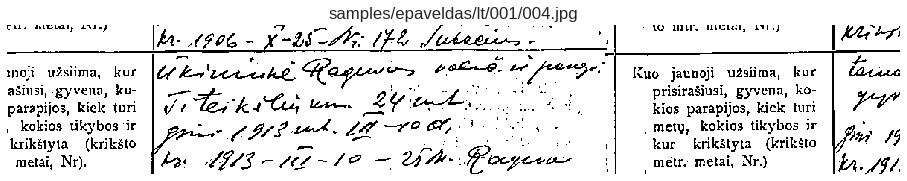

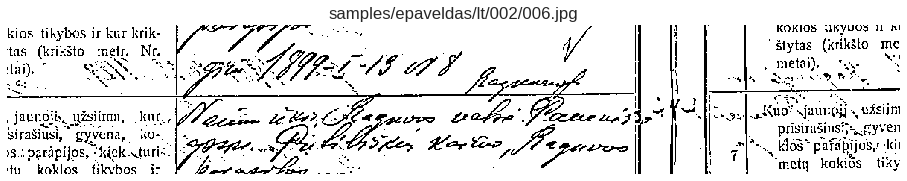

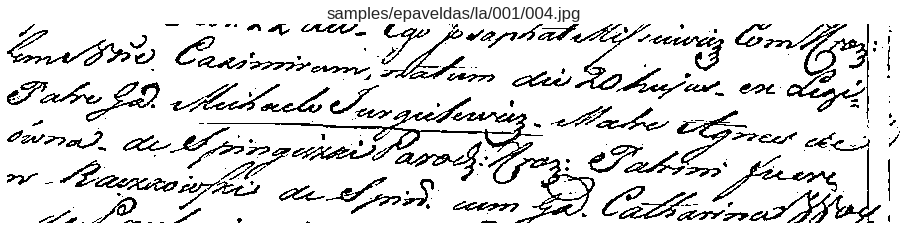

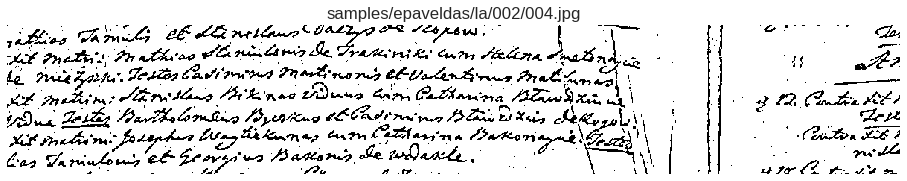

In [218]:
samples = [
    'samples/epaveldas/ru/001/004.jpg',
    'samples/epaveldas/ru/002/004.jpg',
    'samples/epaveldas/ru/003/004.jpg',
    'samples/epaveldas/lt/001/004.jpg',
    'samples/epaveldas/lt/002/006.jpg',
    'samples/epaveldas/la/001/004.jpg',
    'samples/epaveldas/la/002/004.jpg',
]

for sample in samples:
    im = cleanup(cv.imread(sample, cv.IMREAD_GRAYSCALE))
    imshow(im[800:1000, 300:1500], title=sample)

## How to identify possition of each letter in the image?

In [20]:
im = cleanup(cv.imread(sample, cv.IMREAD_GRAYSCALE))
im.shape

(1994, 2466)

### Option 1: Scan all possible letter positions (a brute force way)

In [27]:
print(f'{im.size:,d}')

4,917,204


In [28]:
print(f'{im.size * 30:,d}')

147,516,120


### Option 2: Scan only non empty areas

In [292]:
def pad(a, w, fill=0):
    before = [0] * a.ndim
    after = [w - x % w if x % w else 0 for x in a.shape]
    return np.pad(a, list(zip(before, after)), 'constant', constant_values=fill)

a = pad(np.array([[1, 1],
                  [1, 1]]), 4)
a

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [271]:
a[2:, 2:] = 2
a

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 2, 2],
       [0, 0, 2, 2]])

In [272]:
h, w = 4 // 2, 4 // 2
a = (
    a.reshape(h, 2, w, 2).
     swapaxes(1, 2).       # -> h, w, 2, 2
     reshape(-1, 2 * 2)    # -> h * w, 2 * 2
)
a

array([[1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [2, 2, 2, 2]])

In [273]:
a.reshape(-1, 2, 2)

array([[[1, 1],
        [1, 1]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[2, 2],
        [2, 2]]])

In [274]:
a[-1] = 2
a.reshape(h, w, 2, 2).swapaxes(2, 1).reshape(h * 2, w * 2)

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 2, 2],
       [0, 0, 2, 2]])

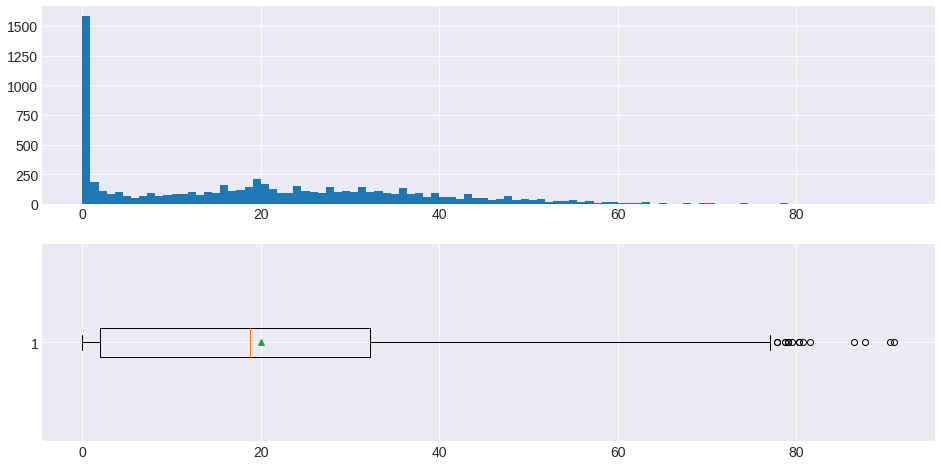

In [275]:
im = cleanup(cv.imread(samples[0], cv.IMREAD_GRAYSCALE))
box = 25
paddedim = pad(im, box)
h, w = (d // box for d in paddedim.shape)
boxes = paddedim.reshape(h, box, w, box).swapaxes(1, 2).reshape(-1, box * box)
means = boxes.mean(axis=1)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax2.boxplot(means, vert=False, showmeans=True)
ax1.hist(means, bins=100)
plt.show()

In [286]:
a = np.arange(12).reshape(3, 4)
np.pad(a, [(0, 2), (0, 0)], 'constant', constant_values=0)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

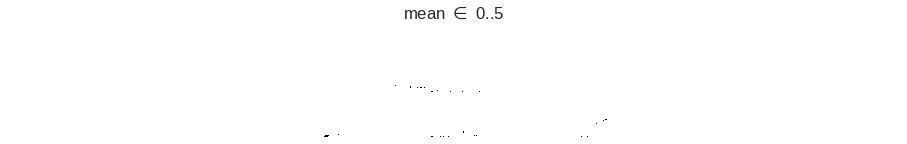

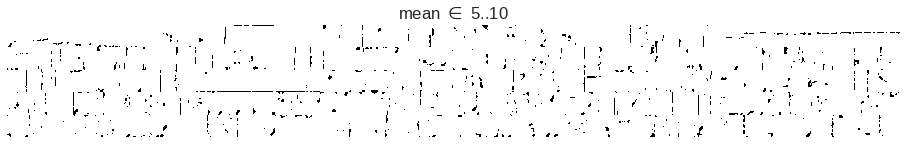

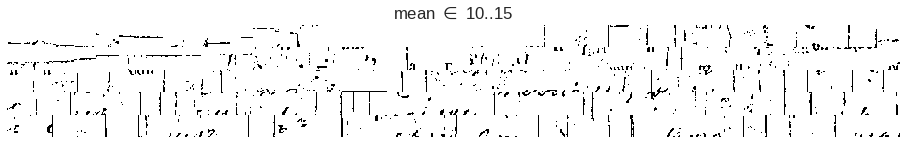

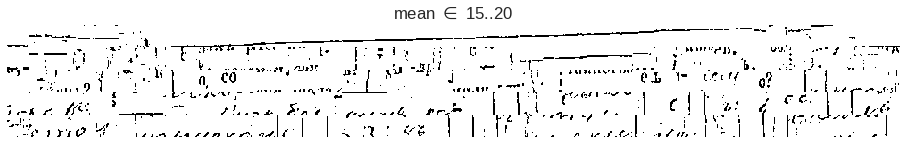

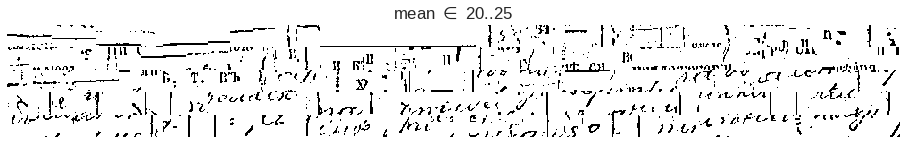

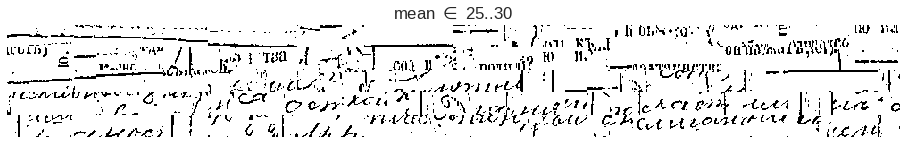

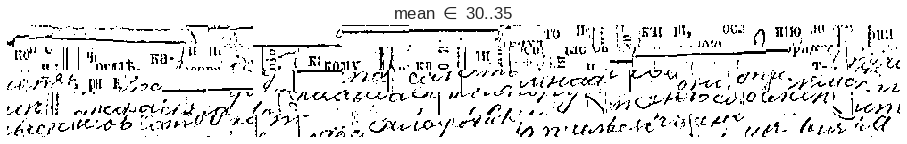

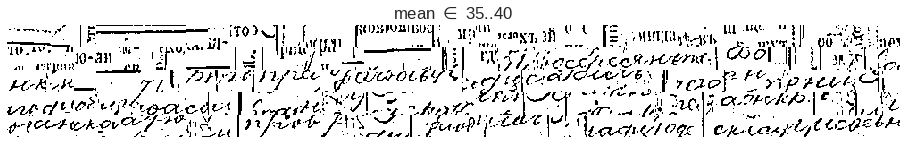

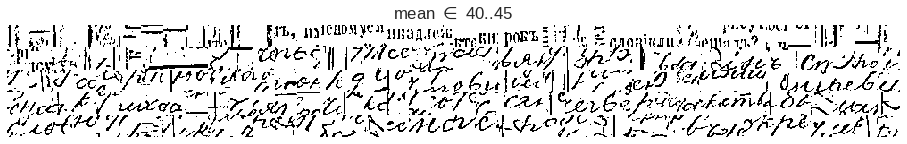

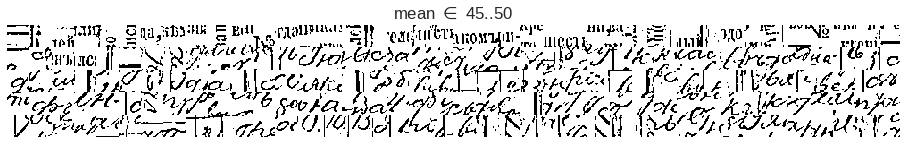

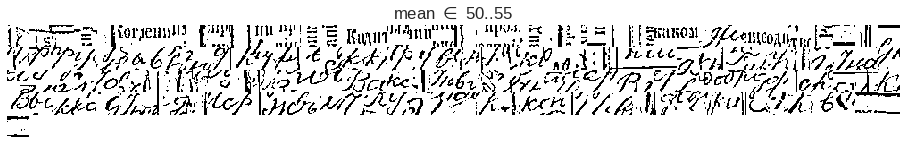

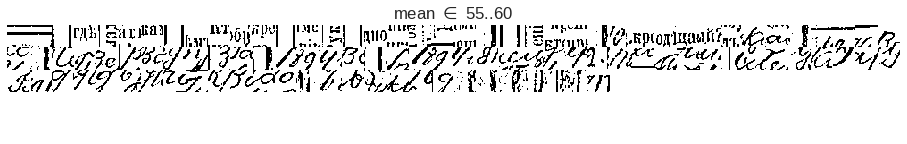

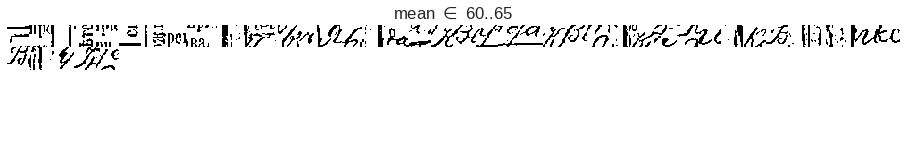

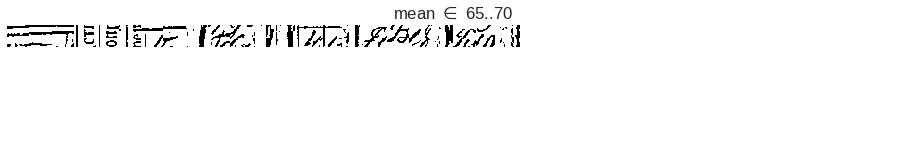

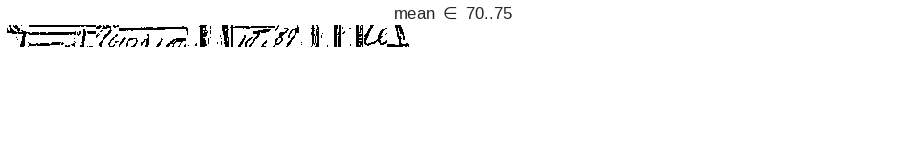

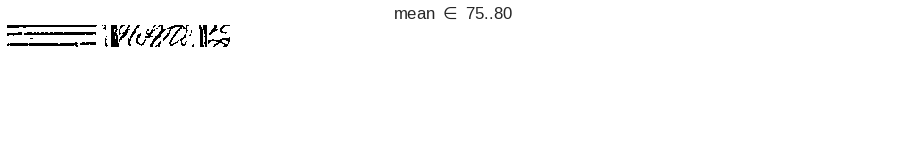

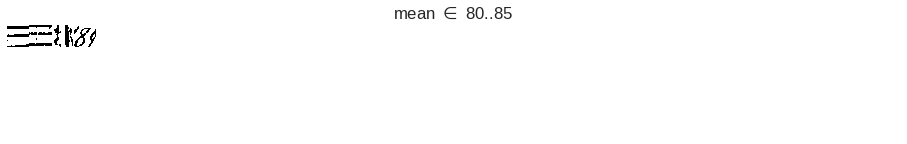

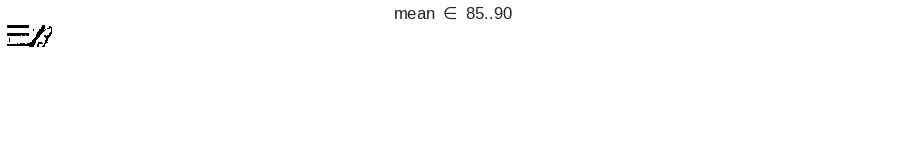

In [287]:
step = 5
h, w = 5, 40
for i in range(0, 90, step):
    mask = (means >= i) & (means < i + step)
    pad_ = h * w - mask.sum() if h * w > mask.sum() else 0 
    im = (
        np.pad(boxes[mask][:h * w], [(0, pad_), (0, 0)], 'constant', constant_values=0).
        reshape(h, w, 25, 25).
        swapaxes(2, 1).
        reshape(h * 25, w * 25)
    )
    imshow(im, title=fr'mean $\in$ {i}..{i + step}')

### Option 3: scan only text lines

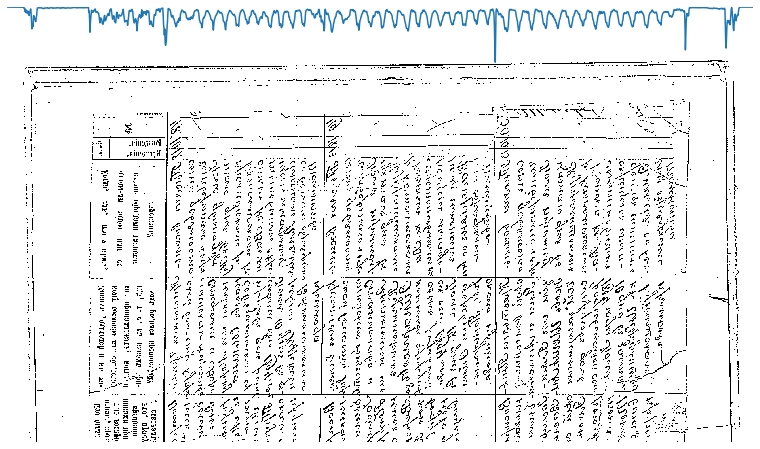

In [324]:
im = cleanup(cv.imread(samples[0], cv.IMREAD_GRAYSCALE))
im = im[:, :1000]
plt.plot(im.mean(axis=1))
imshow(np.pad(im.T, [(100, 0), (0, 0)], 'constant'))
plt.show()

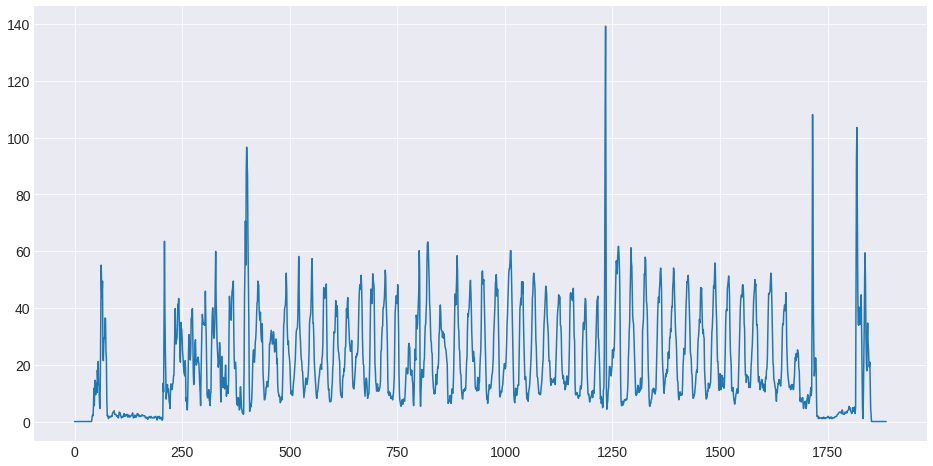

In [325]:
plt.plot(im.mean(axis=1))

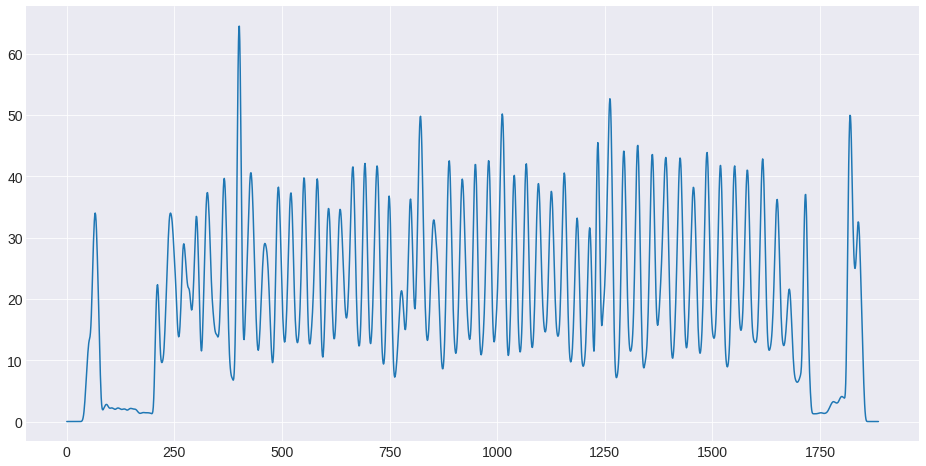

In [327]:
window = signal.hann(20)
plt.plot(signal.convolve(im.mean(axis=1), window, mode='same') / sum(window))

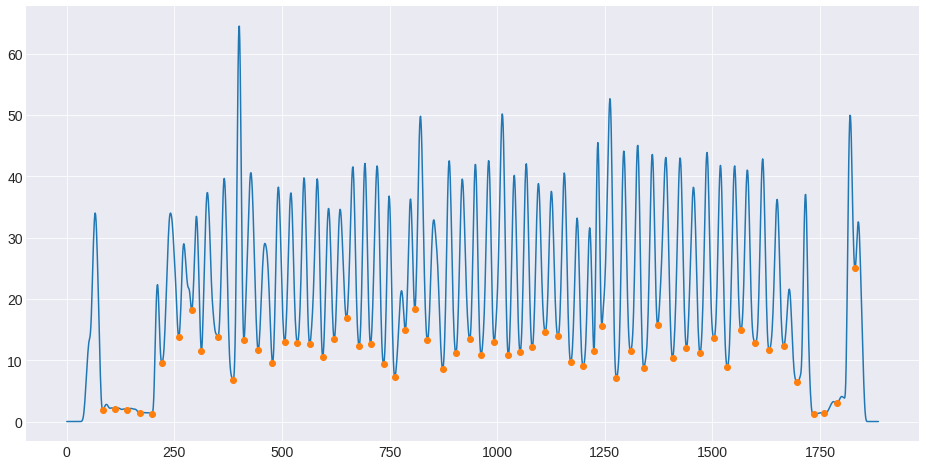

In [354]:
means = im.mean(axis=1)

window = signal.hann(20)
convolved = signal.convolve(means, window, mode='same') / sum(window)
plt.plot(convolved)

minimums = signal.argrelextrema(convolved, np.less, order=10)[0]
plt.plot(minimums, convolved[minimums], 'o')

plt.show()

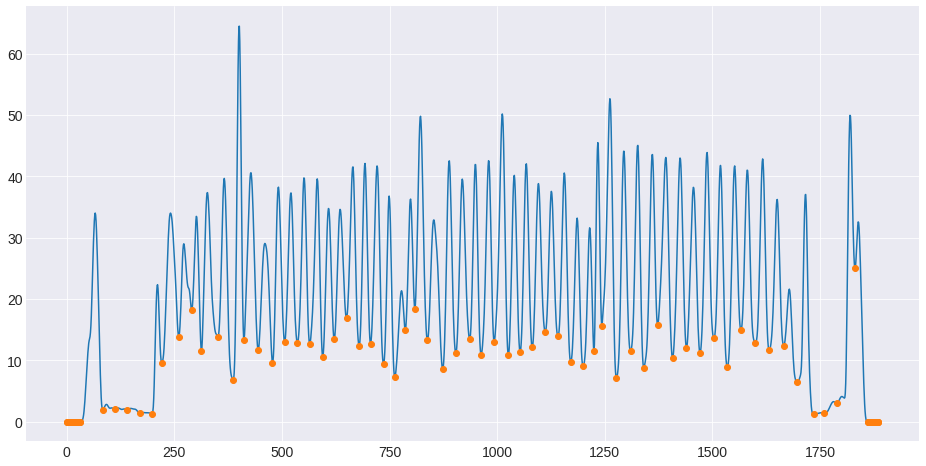

In [355]:
plt.plot(convolved)

minimums = signal.argrelextrema(convolved, np.less_equal, order=10)[0]
plt.plot(minimums, convolved[minimums], 'o')

plt.show()

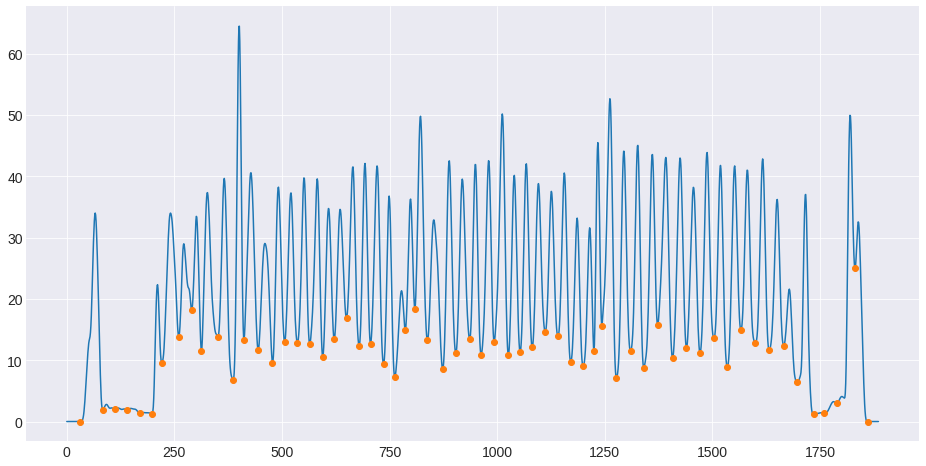

In [356]:
means = im.mean(axis=1)

window = signal.hann(20)
convolved = signal.convolve(means, window, mode='same') / sum(window)
plt.plot(convolved)

minimums = signal.argrelextrema(convolved, np.less_equal, order=10)[0]
minimums = minimums[signal.convolve(np.diff(minimums), [.5, .5], mode='full') > 5]
plt.plot(minimums, convolved[minimums], 'o')

plt.show()

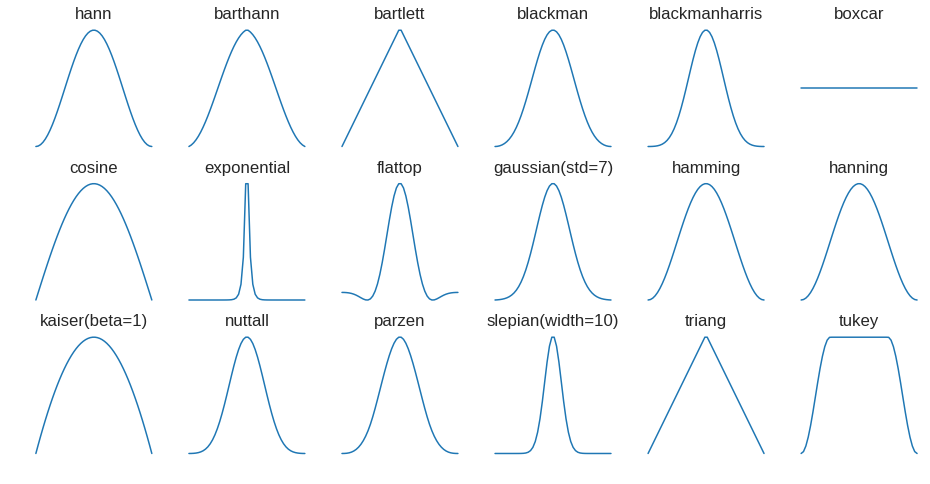

In [357]:
### size = 50
windows = [
    ('hann', signal.hann(size)),
    ('barthann', signal.barthann(size)),
    ('bartlett', signal.bartlett(size)),
    ('blackman', signal.blackman(size)),
    ('blackmanharris', signal.blackmanharris(size)),
    ('boxcar', signal.boxcar(size)),
    ('cosine', signal.cosine(size)),
    ('exponential', signal.exponential(size)),
    ('flattop', signal.flattop(size)),
    ('gaussian(std=7)', signal.gaussian(size, std=7)),
    ('hamming', signal.hamming(size)),
    ('hanning', signal.hanning(size)),
    ('kaiser(beta=1)', signal.kaiser(size, beta=1)),
    ('nuttall', signal.nuttall(size)),
    ('parzen', signal.parzen(size)),
    ('slepian(width=10)', signal.slepian(size, width=10)),
    ('triang', signal.triang(size)),
    ('tukey', signal.tukey(size)),
]

cols = 6
rows = int(np.ceil(len(windows) / cols))
fig, axes = plt.subplots(rows, cols)

for ax in np.ravel(axes):
    ax.axis('off')

for ax, (title, window) in zip(np.ravel(axes), windows):
    ax.plot(window)
    ax.set_title(title)
    
plt.show()

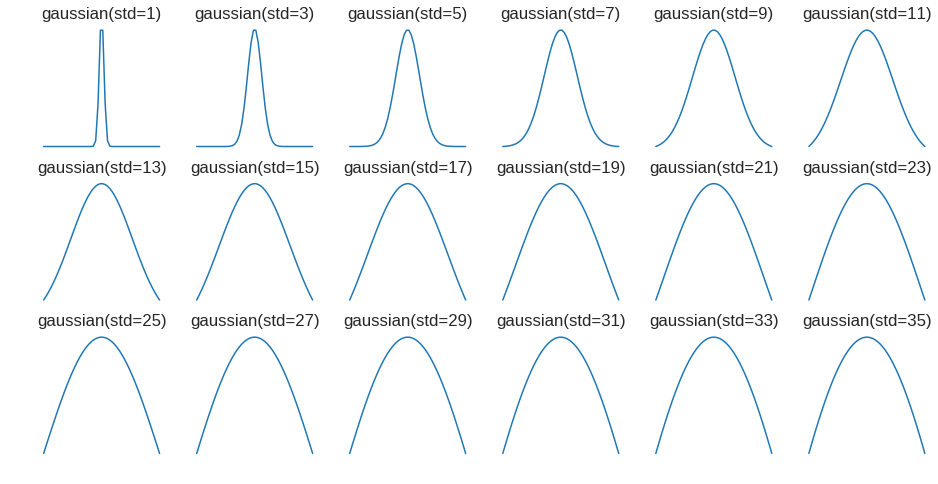

In [347]:
size = 50
cols = 6
rows = 3
fig, axes = plt.subplots(rows, cols)

for ax in np.ravel(axes):
    ax.axis('off')

for ax, std in zip(np.ravel(axes), range(1, cols * rows * 2 + 1, 2)):
    ax.plot(signal.gaussian(size, std=std))
    ax.set_title(f'gaussian(std={std})')
    
plt.show()

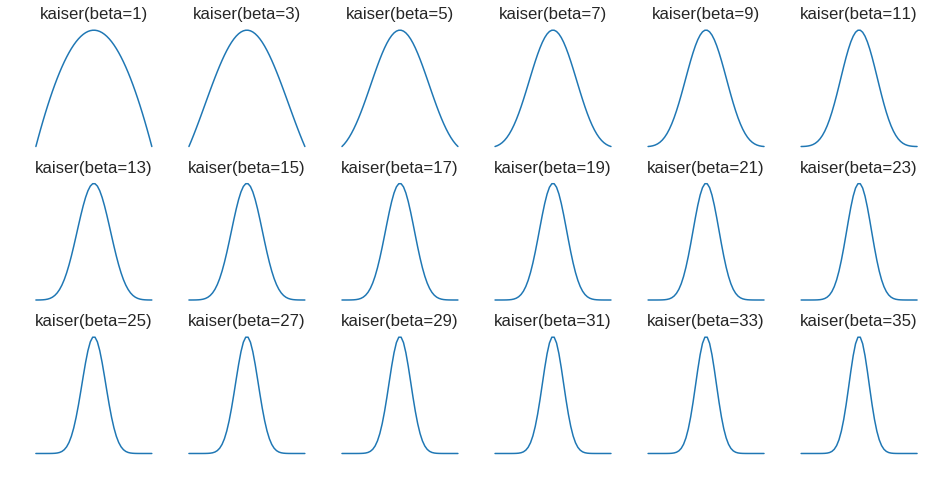

In [348]:
size = 50
cols = 6
rows = 3
fig, axes = plt.subplots(rows, cols)

for ax in np.ravel(axes):
    ax.axis('off')

for ax, beta in zip(np.ravel(axes), range(1, cols * rows * 2 + 1, 2)):
    ax.plot(signal.kaiser(size, beta=beta))
    ax.set_title(f'kaiser(beta={beta})')
    
plt.show()